For a BH of mass $M$ spin $\chi\in [0,1]$, the irreducible mass is 
$$ M_{\rm irr} = %\sqrt{\frac{M^2+\sqrt{M^4-S^2}}{2}} = 
 M \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}}
$$

For convenience, let us define 

$$f(\chi) = \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}} = \frac{M_{\rm irr}}{M}$$

Let's assume that

- the spin $\chi$ is uniformly distributed between 0 and 1.
- the mass $M$ is normally distributed with mean $\mu$ and standard deviation $\sigma$.

**Tasks**:

1. Start with a value of $\sigma=0.02$. Note that $\mu$ is a scale and not a parameter: you can normalize all quantities with a dimension of mass by $\mu$. Just set $\mu=1$ in your code and remember that all masses in the problem are measured in units of $\mu$. 

2. Plot the resulting pdf of $M_{\rm irr}$. First try an histogram with one the rules of thumb we've seen above.

*Hint*: You don't know the functional form of the pdf of $M_{\rm irr}$... but you don't need it if you just want to generate samples! That's the nice thing about numerics!



In [1]:
import numpy as np
from matplotlib import pyplot as plt

import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import uniform
import scipy.stats
from scipy import optimize

from astroML import stats as astroMLstats
from sklearn.neighbors import KernelDensity

plt.rc('text', usetex=True)  
plt.rc('font', family='serif')
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
def f_eq(chi):
    return ((1.+(1.-chi**2.)**0.5)/2.)**0.5
    
def M_irriducible (m, chi):
    return f_eq(chi) * m

In [3]:
np.random.seed(12) 
mu = 1
sigma = 0.02
N = 1000
mass = np.random.normal (mu, sigma, size = N)

In [4]:
spin = np.random.uniform(0,1, N)
#plt.hist(spin, bins=int(1000**0.5), density=True)

In [5]:
M_irr = M_irriducible(mass, spin)
f = f_eq(spin)

## Bin size with the  "Freedman-Diaconis rule" and "Scott's rule":

In [6]:
sigmaG = astroMLstats.sigmaG(M_irr)
binsizeFD = 2.7*sigmaG/(N**(1/3))
print(f'Binsize with Freedman-Diaconis rule: {binsizeFD}')
binsFD = np.append(np.arange(start=M_irr.min(), stop=M_irr.max(), step=binsizeFD) , M_irr.max()) 

sigmaS = np.std(M_irr)
binsizeS = 3.5*sigmaS/(N**(1/3))
print(f'Binsize with Scott rule: {binsizeS}')
binsS = np.append(np.arange(start=M_irr.min(), stop=M_irr.max(), step=binsizeS) , M_irr.max()) 

Binsize with Freedman-Diaconis rule: 0.01599588581380868
Binsize with Scott rule: 0.02319328550728277


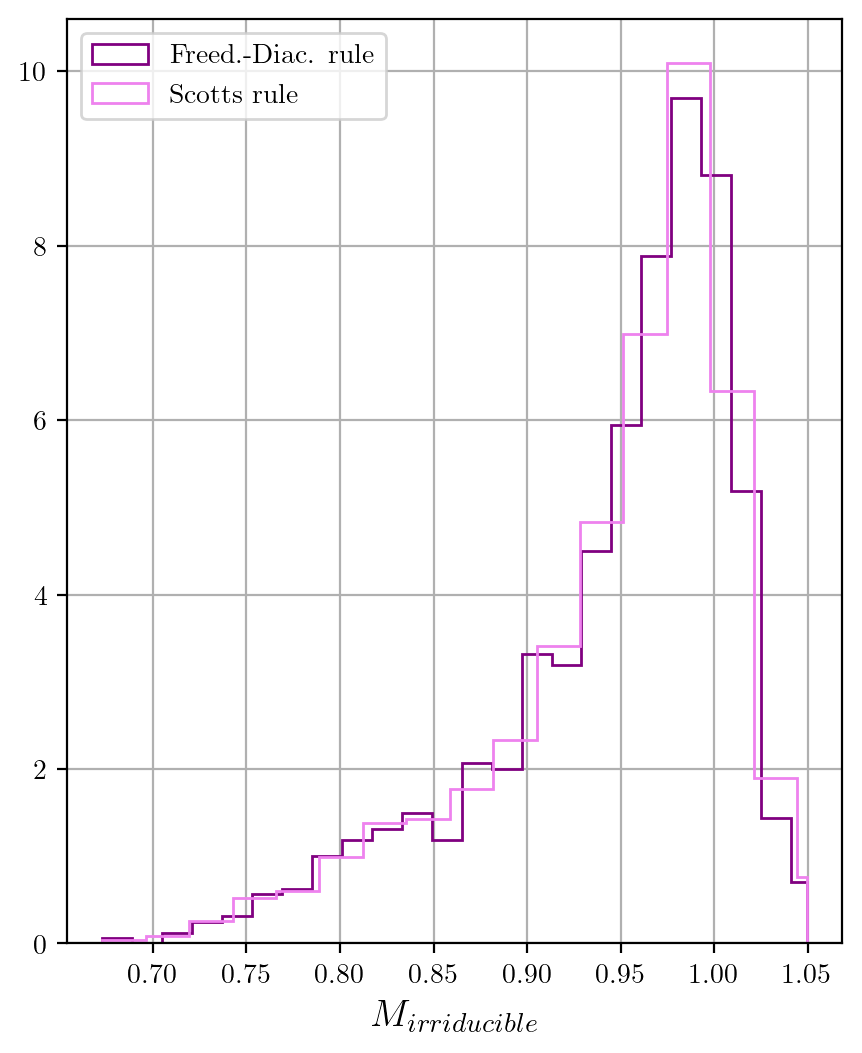

In [7]:
plt.figure(figsize=(5, 6))
plt.hist(M_irr, bins=binsFD, density=True, histtype="step", label='Freed.-Diac. rule', color='purple')
plt.hist(M_irr, bins=binsS, density=True, histtype="step", label='Scotts rule', color='violet')
plt.xlabel('$M_{irriducible}$', fontsize=14)
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [8]:
sigmaG = astroMLstats.sigmaG(f)
binsizeFD = 2.7*sigmaG/(N**(1/3))
print(f'Binsize with Freedman-Diaconis rule: {binsizeFD}')
binsFD = np.append(np.arange(start=f.min(), stop=f.max(), step=binsizeFD) , f.max()) 

sigmaS = np.std(f)
binsizeS = 3.5*sigmaS/(N**(1/3))
print(f'Binsize with Scott rule: {binsizeS}')
binsS = np.append(np.arange(start=f.min(), stop=f.max(), step=binsizeS) , f.max()) 

Binsize with Freedman-Diaconis rule: 0.01526688013042792
Binsize with Scott rule: 0.022043337069069663


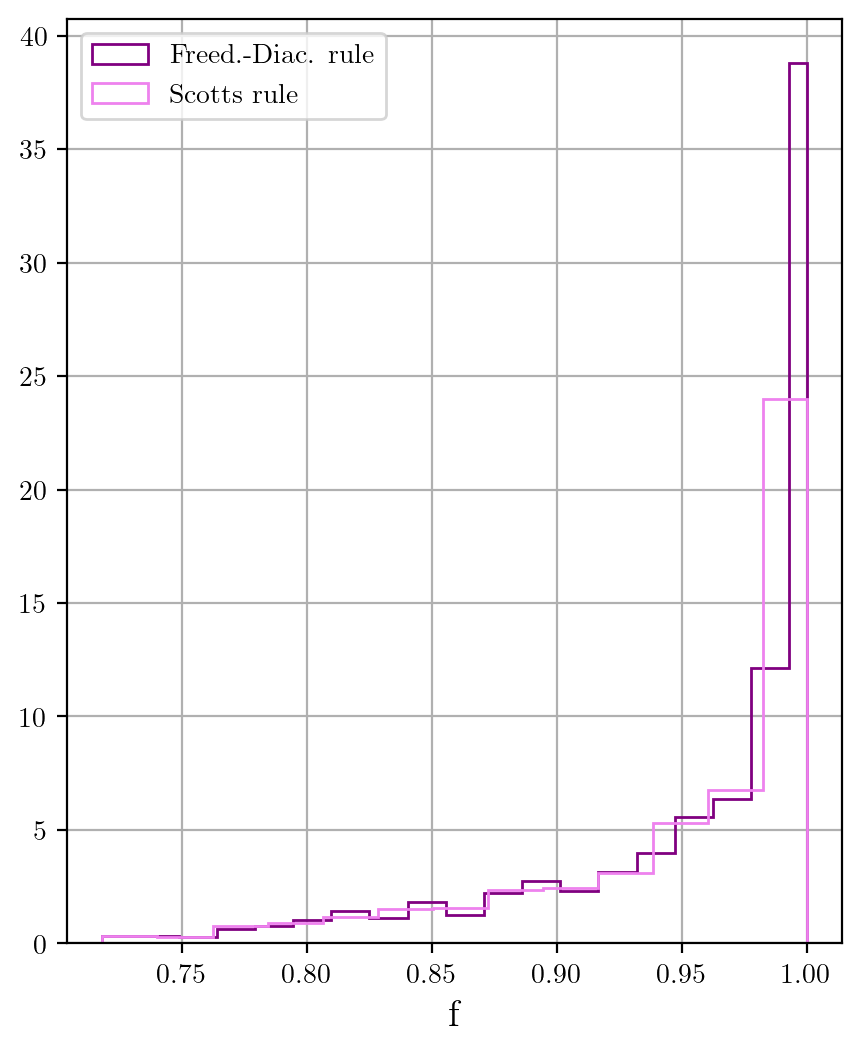

In [9]:
plt.figure(figsize=(5, 6))
plt.hist(f, bins=binsFD, density=True, histtype="step", label='Freed.-Diac. rule', color='purple')
plt.hist(f, bins=binsS, density=True, histtype="step", label='Scotts rule', color='violet')
plt.xlabel('f', fontsize=14)
plt.legend(loc='upper left')
plt.grid()
plt.show()

3. Using the same samples, plot the distribution of $M_{\rm irr}$ using a KDE.


## KDE 

In [10]:
def kde_sklearn(data, xgrid, bandwidth = 1.0, kernel="linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, 
                            kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

In [11]:
Mgrid = np.linspace(M_irr.min(),M_irr.max(),1000)

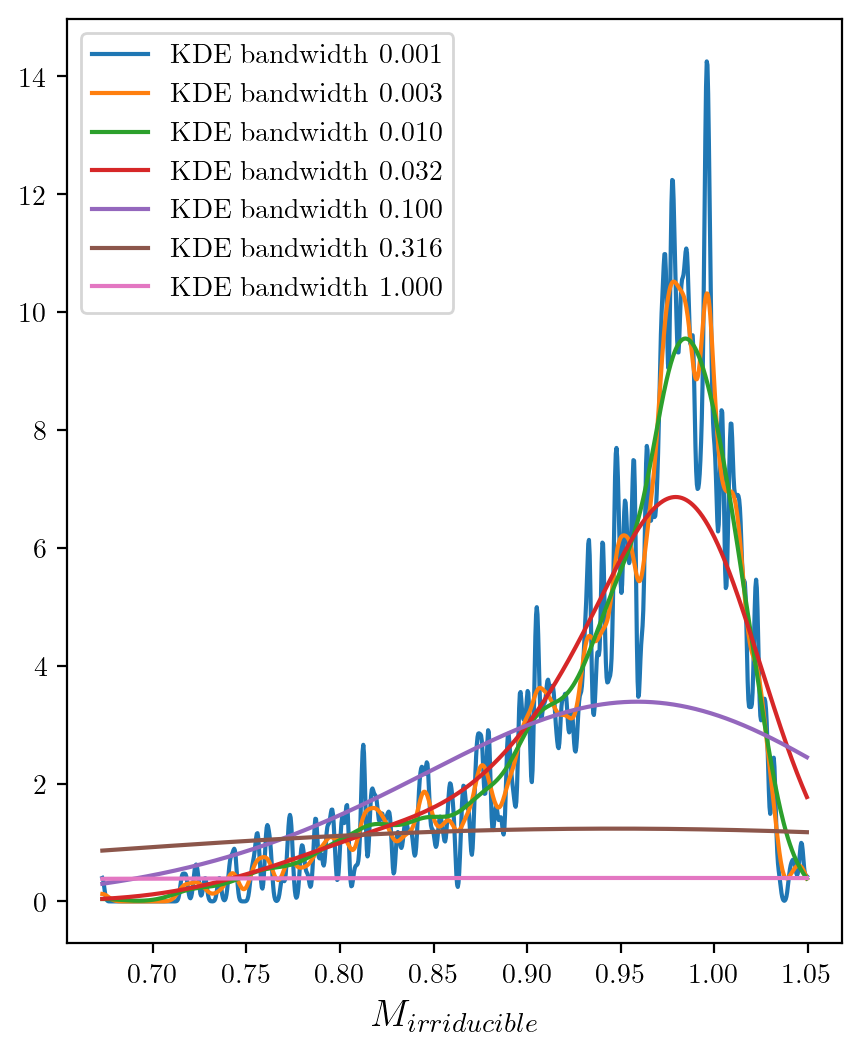

In [12]:
widths = np.logspace(-3, 0, 7)

plt.figure(figsize=(5, 6))
for w in widths:
    PDFtophat = kde_sklearn(M_irr, Mgrid, bandwidth=w,kernel="gaussian")
    plt.plot(Mgrid,PDFtophat, label=f'KDE bandwidth {w:.3f}')
    plt.xlabel('$M_{irriducible}$', fontsize=14)

plt.legend()
plt.show()

In [13]:
fgrid = np.linspace(f.min(),f.max(),1000)

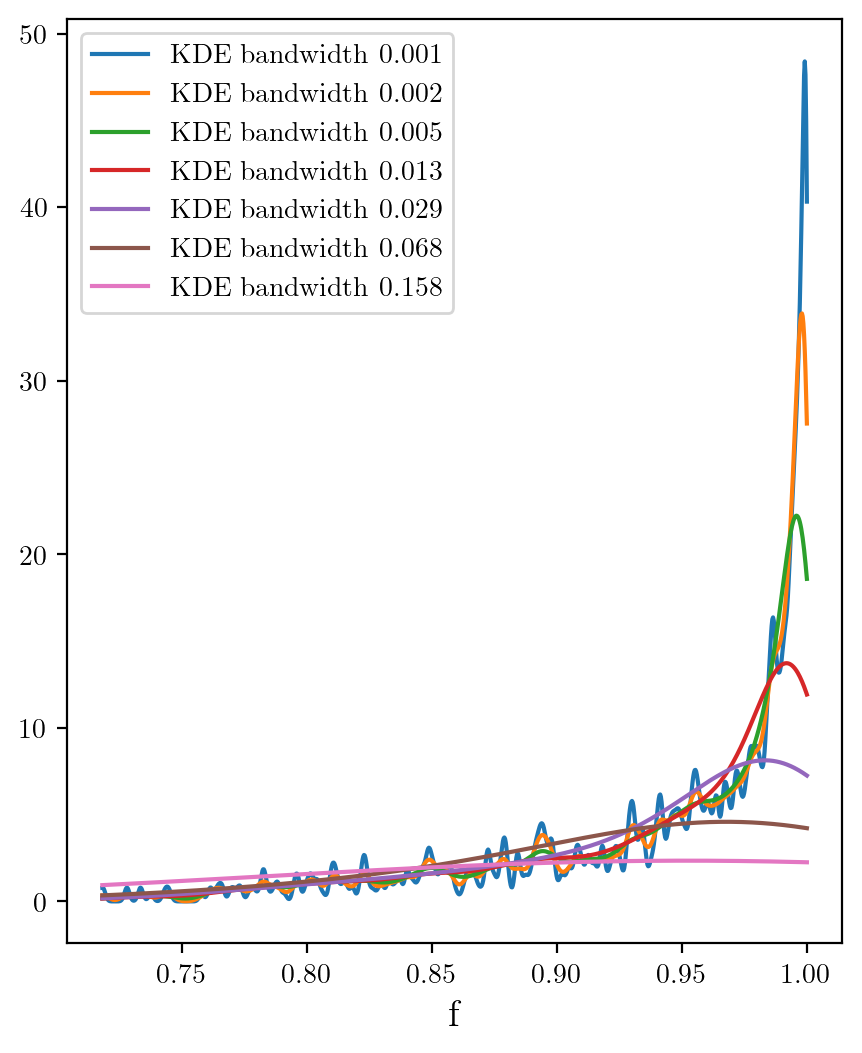

In [14]:
widths = np.logspace(-3, -0.8, 7)

plt.figure(figsize=(5, 6))
for w in widths:
    PDFtophat = kde_sklearn(f,fgrid,bandwidth=w,kernel="gaussian")
    plt.plot(fgrid,PDFtophat, label=f'KDE bandwidth {w:.3f}')
    plt.xlabel('f', fontsize=14)

plt.legend()
plt.show()

4. Compute the KS distance between ${M_{\rm irr}}$ and ${f}$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$. 

5. Compute the KS distance between ${M_{\rm irr}}$ and $M$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$.

## KS tests
measure max difference between cdfs

In [15]:
sigma = np.logspace(-4, 4, 100)

D_Mf = []
D_MM = []
for s in sigma:
    mass = np.random.normal (mu, s, size = N)
    M_irr = M_irriducible(mass, spin) 
    f = M_irr/mass
    D_Mf.append((scipy.stats.ks_2samp(f, M_irr)))
    D_MM.append((scipy.stats.ks_2samp(mass, M_irr)))

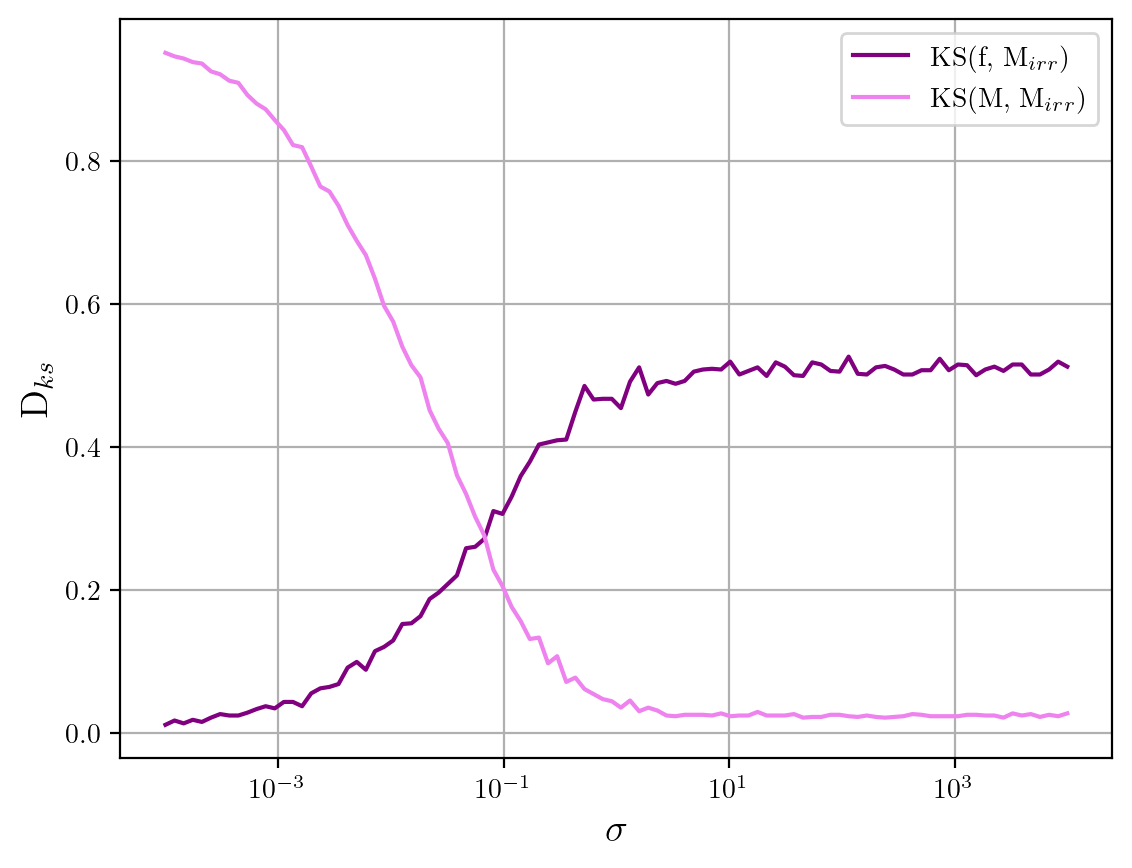

In [16]:
plt.plot(sigma, (np.array(D_Mf))[:,0], label='KS(f, M$_{irr}$)', color='purple')
plt.plot(sigma, (np.array(D_MM))[:,0], label='KS(M, M$_{irr}$)', color='violet')
plt.xlabel('$\sigma$', fontsize=14)
plt.ylabel('D$_{ks}$', fontsize=14)
plt.xscale('log')
plt.grid()
plt.legend()
plt.show()

For small $\sigma$ the irriducible mass is distributed like f and for large valued of $\sigma$ as f. The two models are equal around $\sigma$=0.06


7. Compute the pdfs of $M_{\rm irr}$ from their mathematical definitions, plot them, and check they agree with your KDE.

*Hint (for point 7 above)*: First compute the pdf of $f$, that is just a change of variable. We saw how to do this in a previous lecture. The answer is:
\begin{equation}
\pi(f) = 2\frac{2 f^2-1}{\sqrt{1 - f^2}}\,.
\end{equation}

*Another hint (still for point 7 above)*: Then compute the pdf of $M_{\rm irr}$, you want to use [this theorem](https://en.wikipedia.org/wiki/Distribution_of_the_product_of_two_random_variables) for the product of two random variables. The answer is only semi-analytic (unless you know how to solve that integral? If so please tell me!)
$$
p(M_{\rm irr})  = \frac{\sqrt{2/\pi}}{\sigma} \int_{1/\sqrt{2}}^1 \exp\left[{-\frac{(M_{\rm irr}/f -\mu)^2}{2\sigma^2}}\right]  \frac{2 f^2-1}{f \sqrt{1 - f^2}}  \,\, {\rm d}f\,.
$$
This can be easily solved numerically.

*Yet another hint:* If any any time you get lost in the calculation, it helps checking that your pdfs are normalized as they should.

### My sol

compute inverse of f($\chi$):
$$ \chi = \sqrt{1-(2f^2-1)^2} $$

$$ |\frac{d\chi}{df}| = \frac{2(2f^2-1)}{\sqrt{1-f^2}}$$

$$ p(f)=p(\chi)  |\frac{d\chi}{df}| =  |\frac{d\chi}{df}|  = \pi (f)$$

(bc  $p(\chi) = 1$)


In [17]:
def pdf_f(f_val):
    return 2 * (2 * f_val**2 - 1) / np.sqrt(1 - f_val**2)
'''
#viene evidentemente brutta e sbagliata
def pdf_M_irr(f, M_irr, mu, sigma):
    
    norm = 1/sigma * np.sqrt(2/np.pi)
    m_irr = [norm * np.trapz((2*f**2 - 1)/(f*np.sqrt(1-f**2)) * 
             np.exp(-(m/f - mu)**2 / (2*sigma**2)), f) for m in M_irr]
    
    return np.array(m_irr)[np.argsort(M_irr)]'''

def integrand(f, M_irr, mu, sigma):
    return np.exp(-(M_irr/f - mu)**2 / (2*sigma**2)) * (2*f**2 - 1) / (f * np.sqrt(1 - f**2))


def pdf_M_irr(M_irr, mu, sigma):
    result, _ = scipy.integrate.quad(lambda f: integrand(f, M_irr, mu, sigma), 1/np.sqrt(2), 1)
    return np.sqrt(2/np.pi) / sigma * result

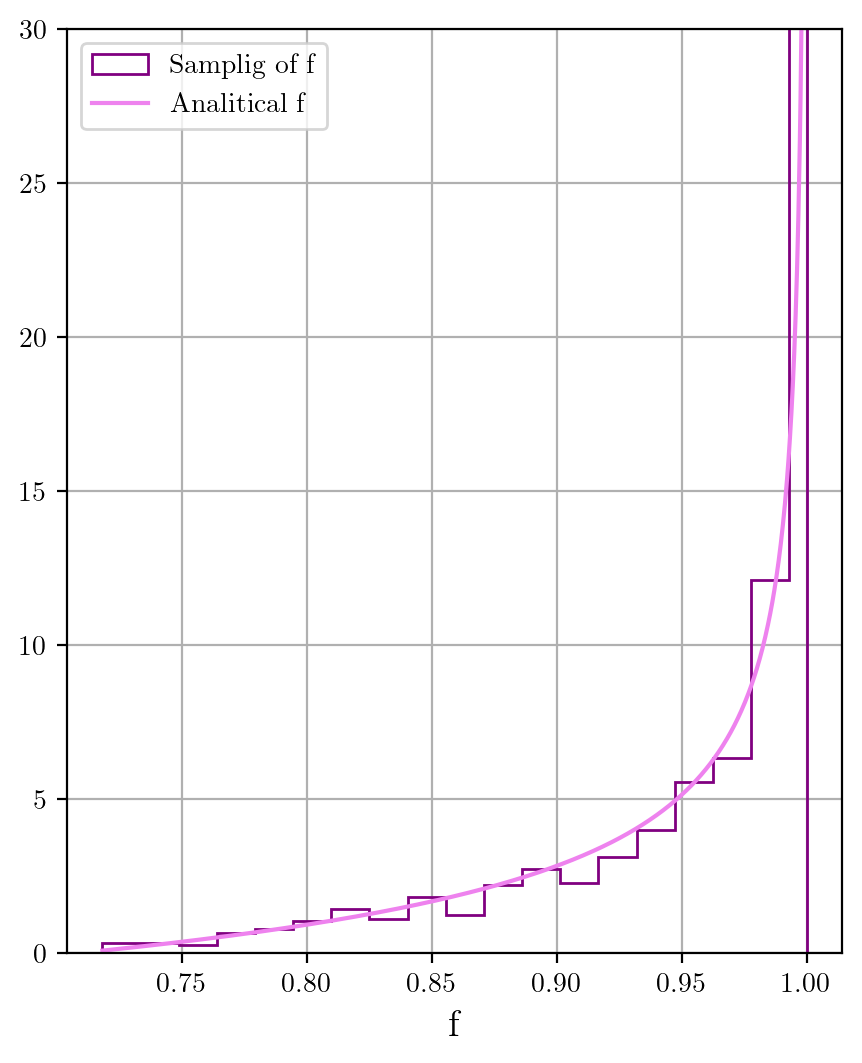

In [18]:
plt.figure(figsize=(5, 6))
plt.hist(f, bins=binsFD, density=True, histtype="step", label='Samplig of f', color='purple')
plt.plot(fgrid, pdf_f(fgrid), color='violet', label='Analitical f')
plt.xlabel('f', fontsize=14)
plt.legend(loc='upper left')
plt.ylim(0,30)
plt.grid()
plt.show()

In [19]:
#rewrite these bc I am probably using the same name more than once in the code ups

mu = 1
sigma = 0.02
mass = np.random.normal (mu, sigma, size = N)
spin = np.random.uniform(0,1, N)
M_irr = M_irriducible(mass, spin)
f = f_eq(spin)


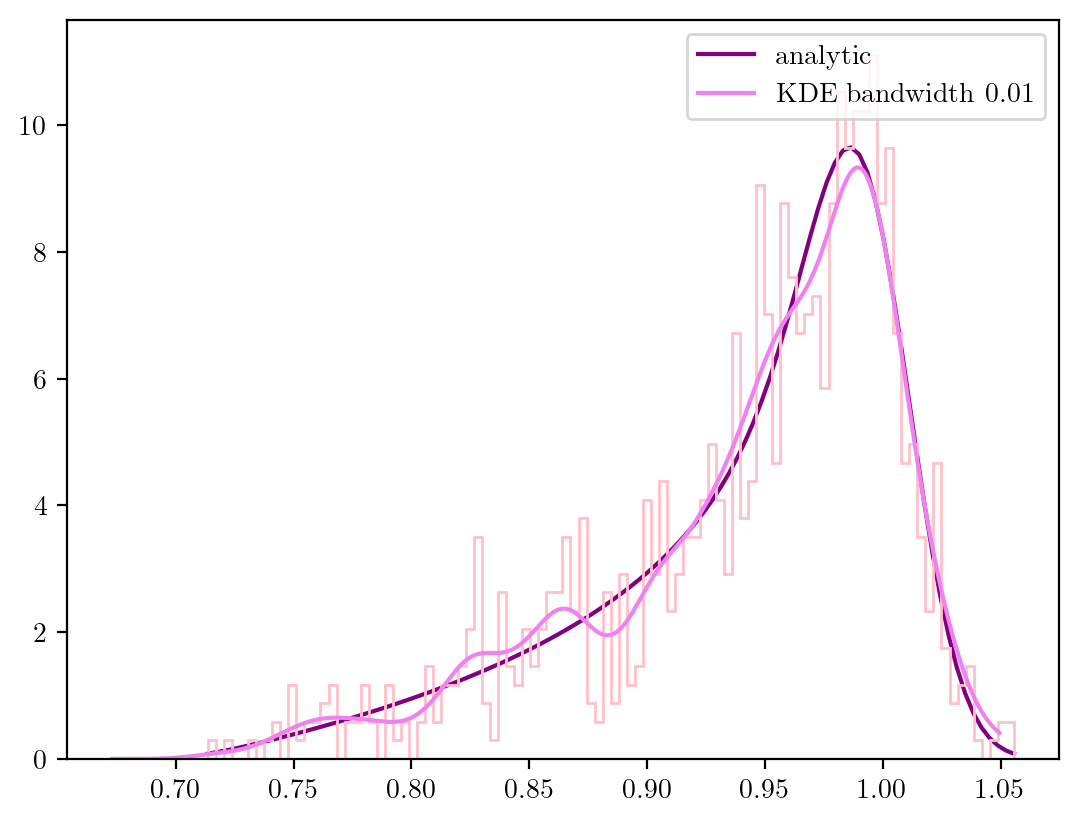

In [20]:
M_irr_grid = np.linspace(M_irr.min(), M_irr.max(), 100)
pdf_values = [pdf_M_irr(m_irr, mu, sigma)  for m_irr in M_irr_grid]
plt.plot(M_irr_grid, pdf_values, label='analytic', color = "purple")
plt.hist(M_irr, bins = 100, density = True,color = 'pink', histtype= 'step');

PDFtophat = kde_sklearn(M_irr, Mgrid, bandwidth=0.01, kernel="gaussian")
plt.plot(Mgrid,PDFtophat, label=f'KDE bandwidth 0.01', color='violet')

plt.legend()
plt.show()